In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.corpus import stopwords 
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
base_csv = './IMDB Dataset/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X,y = df['review'].values,df['sentiment'].values

# 切分訓練集和測試集
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 再從訓練集中切分出驗證集
x_test, x_val, x_test, y_val = train_test_split(x_test, x_test, test_size=0.5, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'shape of train data is {x_train.shape}')
print(f'shape of validation data is {x_val.shape}')
print(f'shape of test data is {x_test.shape}')


shape of train data is (40000,)
shape of validation data is (5000,)
shape of test data is (5000,)


In [15]:
def preprocess_string(s):
    s = s.lower()
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    # remove URL
    s = re.sub(r'https?://\S+|www\.\S+','',s)
    #remove HTML tags
    s = re.sub(r'<.*?>', '', s)

    return s

def filter_stopwords(review):
    stop_words = set(stopwords.words('english')) 
    remain_words = ['but','not','no','nor','too','very']
    #Remove emotional vocab
    for word in remain_words:
        stop_words.discard(word)
        
    words = review.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


In [96]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def filter_stopwords(review):
    stop_words = set(stopwords.words('english')) 
    remain_words = ['but','not','no','nor','too','very']
    # Remove emotional vocab
    for word in remain_words:
        stop_words.discard(word)
        
    lemmatizer = WordNetLemmatizer()
    words = review.split()
    filtered_words = [lemmatizer.lemmatize(word.lower(), pos=wordnet.VERB) 
                      for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


In [97]:
df['new_review']= df['review'].apply(preprocess_string).apply(filter_stopwords)
df[['review','new_review']].head()

,review,new_review
0,One of the other reviewers has mentioned that ...,one reviewers mention watch oz episode youll h...
1,A wonderful little production. <br /><br />The...,wonderful little production br br film techniq...
2,I thought this was a wonderful way to spend ti...,think wonderful way spend time too hot summer ...
3,Basically there's a family where a little boy ...,basically theres family little boy jake think ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stun f...


In [98]:
df['new_review'].head()

0    one reviewers mention watch oz episode youll h...
1    wonderful little production br br film techniq...
2    think wonderful way spend time too hot summer ...
3    basically theres family little boy jake think ...
4    petter matteis love time money visually stun f...
Name: new_review, dtype: object

In [99]:
def tf_idf_df(data):
    # TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)

    # fitting model + transform
    tfidf_matrix = tfidf_vectorizer.fit_transform(data)
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # # 將 TF-IDF 矩陣轉換成布林矩陣，非零元素為 True
    # tfidf_nonzero_mask = tfidf_matrix != 0

    # # 使用布林矩陣選擇非零元素，並計算每列的平均值
    # nonzero_column_means = np.divide(tfidf_matrix.sum(axis=0), tfidf_nonzero_mask.sum(axis=0))

    # # 將得到的平均值轉換成一維數組
    # average_tfidf_values = np.squeeze(np.asarray(nonzero_column_means))
    average_tfidf_values = np.mean(tfidf_df, axis=0)

    # 創建一個包含詞彙和平均TF-IDF值的DataFrame
    average_tfidf_df = pd.DataFrame({'Term': feature_names, 'Average_TF-IDF': average_tfidf_values})

    return average_tfidf_df

In [100]:
positive_tfidf = tf_idf_df(df[df['sentiment']=='positive']['new_review'])
negative_tfidf = tf_idf_df(df[df['sentiment']=='negative']['new_review'])


In [101]:
# outer join
merged_tfidf = positive_tfidf.merge(negative_tfidf, on='Term', suffixes=('_positive', '_negative'), how='outer')
merged_tfidf = merged_tfidf.fillna(0)

merged_tfidf['diff_tfidf'] = merged_tfidf['Average_TF-IDF_positive'] - merged_tfidf['Average_TF-IDF_negative']

In [102]:
merged_tfidf[['Term','diff_tfidf']].sort_values(by=['diff_tfidf'],ascending=False).head()
merged_tfidf[['Term','diff_tfidf']].sort_values(by=['diff_tfidf'],ascending=True).head()

,Term,diff_tfidf
330,bad,-0.016964
4951,worst,-0.011376
4822,waste,-0.010089
3025,no,-0.008436
2916,movie,-0.007738


In [103]:
merged_df = pd.merge(positive_tfidf, negative_tfidf, on='Term', suffixes=('_negative', '_positive'))

# 計算相同 Term 的 Average_TF-IDF 差異
merged_df['TF-IDF_Difference'] = np.abs(merged_df['Average_TF-IDF_negative'] - merged_df['Average_TF-IDF_positive'])
merged_df.sort_values(by='TF-IDF_Difference', ascending=False)


,Term,Average_TF-IDF_negative,Average_TF-IDF_positive,TF-IDF_Difference
278,bad,0.008997,0.025961,1.696437e-02
1610,great,0.023593,0.011836,1.175761e-02
4076,worst,0.001612,0.012988,1.137592e-02
3965,waste,0.001467,0.011556,1.008921e-02
2183,love,0.021835,0.011938,9.897954e-03
...,...,...,...,...
1897,installment,0.000533,0.000532,3.989420e-07
1752,holiday,0.000806,0.000806,2.374484e-07
2782,preachy,0.000386,0.000386,1.323758e-07
2696,physically,0.000582,0.000582,7.162404e-08


In [104]:
merged_tfidf[['Term','diff_tfidf']]

,Term,diff_tfidf
0,aaron,0.000178
1,abandon,-0.000064
2,abc,0.000299
3,abilities,0.000056
4,ability,0.000043
...,...,...
5876,yawn,-0.000640
5877,yep,-0.000400
5878,youtube,-0.000376
5879,zoey,-0.000371


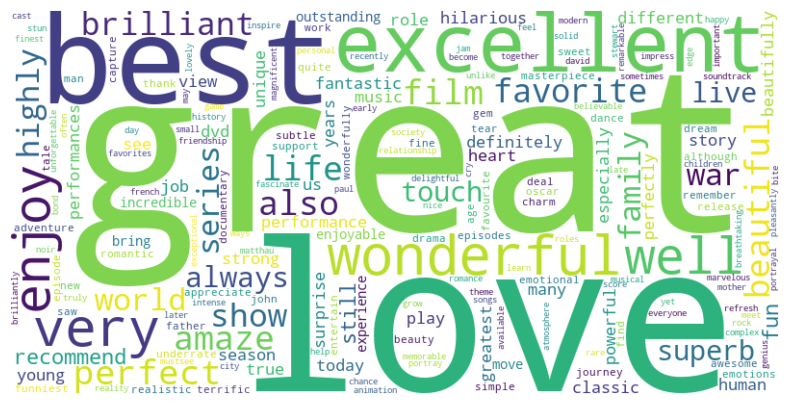

In [105]:
word_diff_tfidf_dict = dict(zip(merged_tfidf['Term'], merged_tfidf['diff_tfidf']))

# 初始化 WordCloud 物件，設置一些參數，如寬度、高度、背景顏色等
wordcloud = WordCloud(width=800, height=400, background_color='white')

# 使用 generate_from_frequencies() 方法生成文字雲
wordcloud.generate_from_frequencies(word_diff_tfidf_dict)

# 顯示文字雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

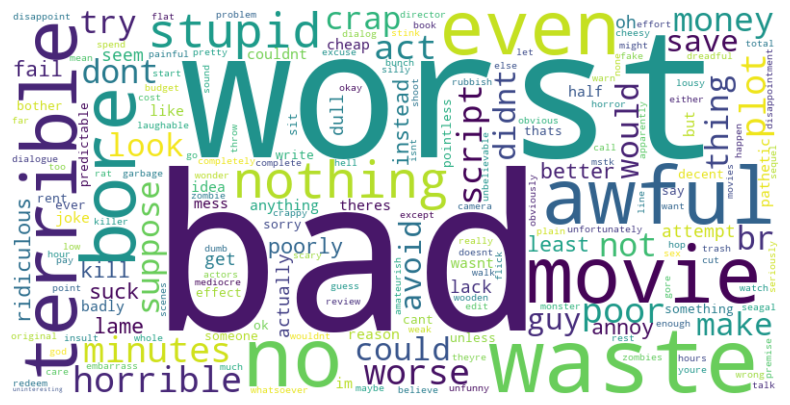

In [106]:
word_diff_tfidf_dict = dict(zip(merged_tfidf['Term'], merged_tfidf['diff_tfidf'].apply(lambda x :x*-1)))

# 初始化 WordCloud 物件，設置一些參數，如寬度、高度、背景顏色等
wordcloud = WordCloud(width=800, height=400, background_color='white')

# 使用 generate_from_frequencies() 方法生成文字雲
wordcloud.generate_from_frequencies(word_diff_tfidf_dict)

# 顯示文字雲
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()